In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
import yfinance as yf

df = yf.download('AAPL', start='2012-01-01', end='2024-01-17')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433823,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500648,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639429,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771557,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751298,394024400
...,...,...,...,...,...,...
2024-01-09,183.919998,185.149994,182.729996,185.139999,184.904053,42841800
2024-01-10,184.350006,186.399994,183.919998,186.190002,185.952713,46792900
2024-01-11,186.539993,187.050003,183.619995,185.589996,185.353485,49128400


In [3]:
df.shape

(3028, 6)

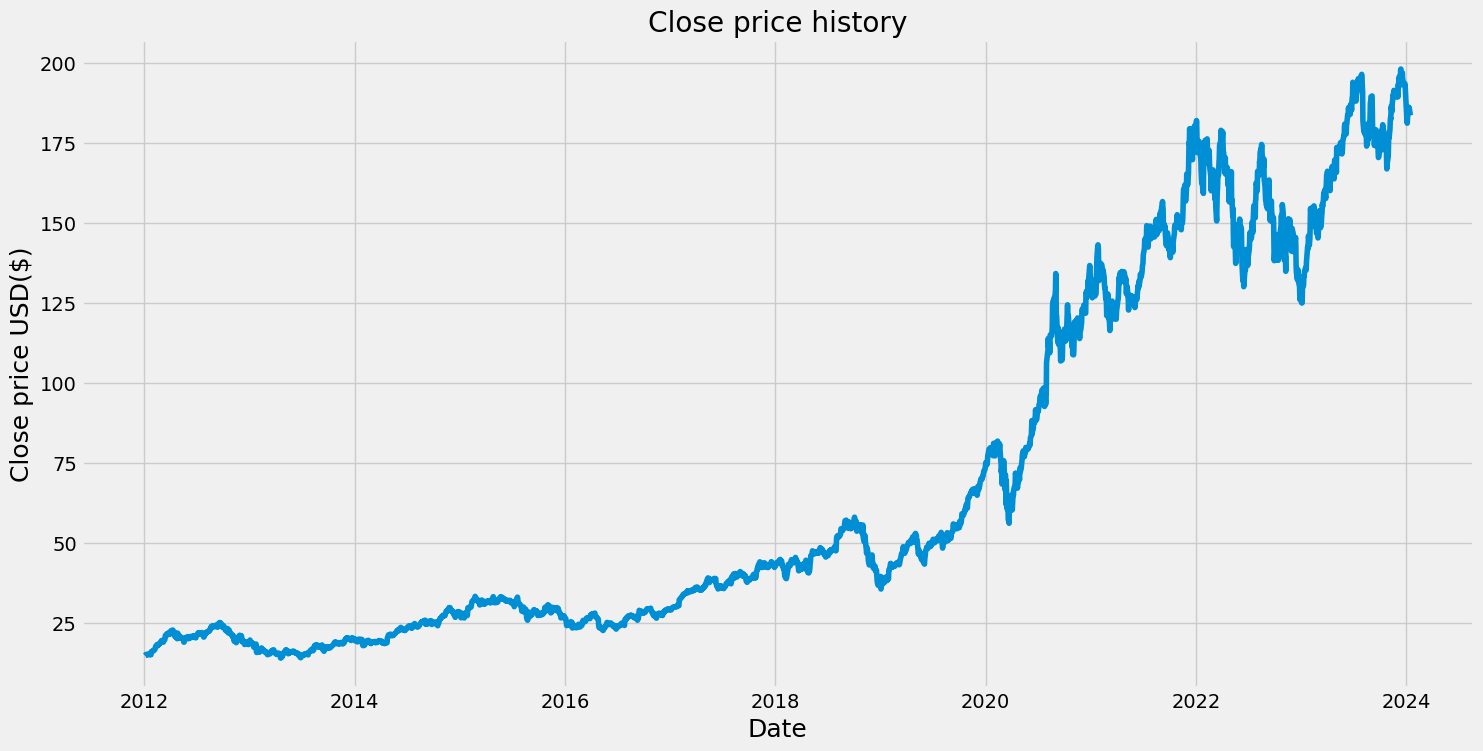

In [4]:
plt.figure(figsize=(16, 8))
plt.title('Close price history')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD($)', fontsize=18)
plt.show()

In [5]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

2423

In [6]:
#scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00401431],
       [0.00444289],
       [0.00533302],
       ...,
       [0.93201654],
       [0.93380844],
       [0.92137381]])

In [7]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<=60:
    print(x_train)
    print(y_train)
    print()

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.00577323, 0.00715207, 0.00579457,
       0.01088518, 0.01049151, 0.01100542, 0.01211663, 0.01278955,
       0.01273332, 0.01252582, 0.01341013, 0.01424207, 0.01518457,
       0.01670691, 0.01990478, 0.01995326, 0.02173353, 0.02306387,
       0.02077746, 0.02165789, 0.02164044, 0.02410915, 0.02375813,
       0.02440779, 0.02557523, 0.0262249 , 0.02809631, 0.02945961,
       0.02985329, 0.02999098, 0.02765997, 0.02709757, 0.02718096,
       0.02937236, 0.02998905, 0.03131358, 0.03443581, 0.03860139,
       0.0378218 , 0.03782373, 0.04083544, 0.04177794, 0.04110694,
       0.04049413, 0.03985611, 0.04197573, 0.0434302 , 0.04403914])]
[0.042534249860459186]



In [8]:
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2363, 60, 1)

In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [11]:
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

2363/2363 [==============================] - 71s 29ms/step - loss: 7.2613e-04


In [13]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [14]:
x_test = np.array(x_test)

In [15]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [16]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

19/19 [==============================] - 1s 15ms/step


In [17]:
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse

9.974803602991026

<ipython-input-18-ac0c04de899b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


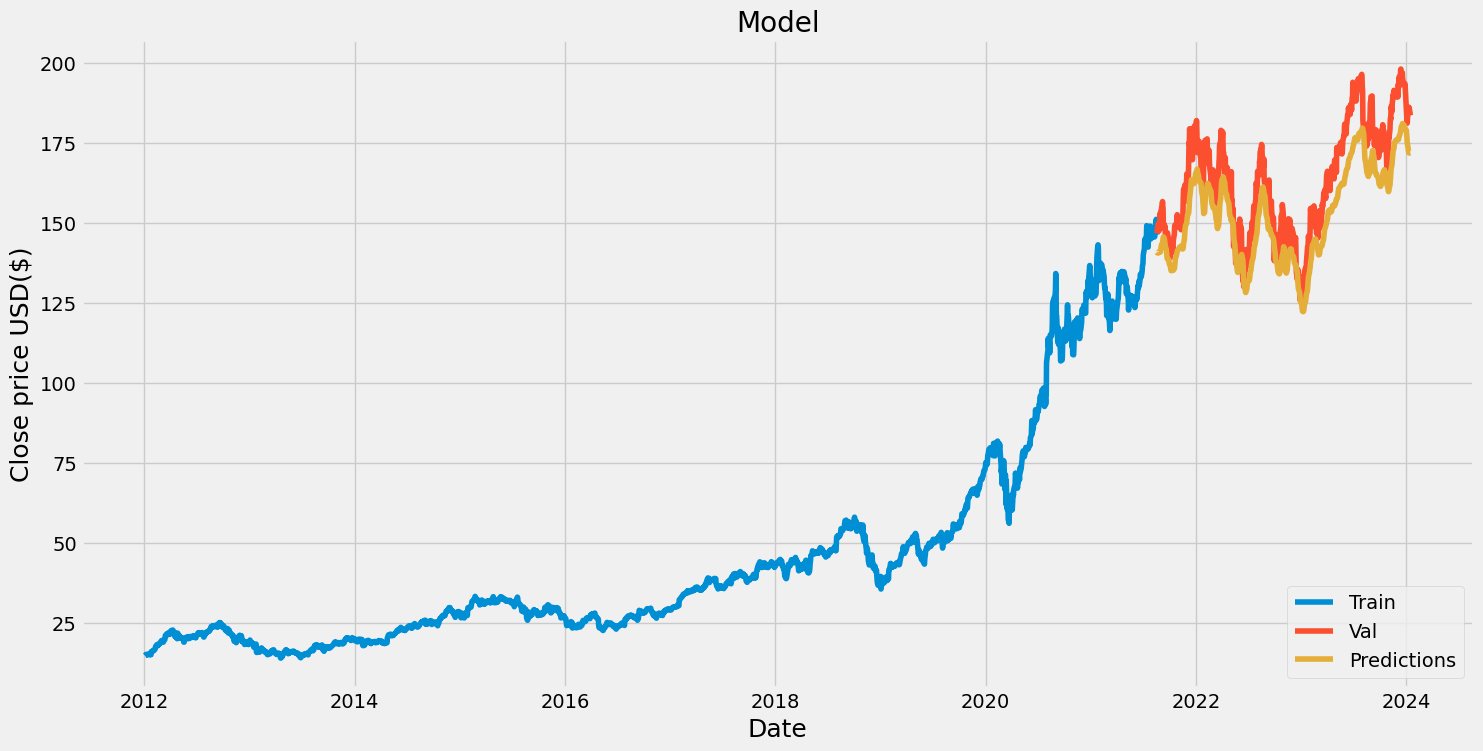

In [18]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD($)', fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()


In [19]:
#Get the quote
import yfinance as yf
apple_quote = yf.download('AAPL', start='2012-01-01', end='2024-01-15')



[*********************100%%**********************]  1 of 1 completed


In [20]:
#Create a new dataframe
new_df = apple_quote.filter(["Close"])

#Get the last 60 days losing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values

#scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

#Create an empty list
X_test = []

#Append the past 60 days
X_test.append(last_60_days_scaled)

X_test = np.array(X_test)

#Convert the X_test data set to a numpy array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))


In [21]:
#Get the predicted scaled price
pred_price = model.predict(X_test)
#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print()
print(pred_price)
print()
apple_quote2 = yf.download('AAPL', start='2024-01-16', end='2024-01-17')
print(apple_quote2["Close"])

1/1 [==============================] - 0s 25ms/step


[*********************100%%**********************]  1 of 1 completed


[[171.93282]]

Date
2024-01-16    183.630005
Name: Close, dtype: float64
